# Preclinical AIF

In [1]:
import os
import numpy
from matplotlib import pyplot as plt
from matplotlib.transforms import offset_copy
import csv
import seaborn as sns
import pandas as pd
import json
from pathlib import Path

## Background
This preclinical AIF is derived from DCE-MRI data of rats described in the the paper of McGrath et al. (MRM 2009).


## Test data
To create the AIF the parameters of the functional form are copied from Table 1, Model B of the reference. The original data had a temp resolution of 0.5 s and tot acquisition time of 300s. This data was labeled as 'Original_AIF'. 
Permutations of this AIF were used to test the implementations:
- various temporal resolutions: 0.5, 1, 2, 2.5, 5, 7.5 s
- various acquistion times: 3, 5, 7, 10 min
- shifts of the AIF with a temporal resolution of 1.5 s (dt): 0, dt, 2*dt, 5*dt, 2, 5, 10, 18, 31

As we don't expect many errors in implementing the population AIFs, the tolerances were set tight.  
Tolerances: absolute + relative = 0.0001 mM + 0.01 and 0.1 mM + 0.1 for the data with a shift.


## Import data

A JSON named `results-meta.json` is created to isolate the meta information. The following script can read this JSON and construct the corresponding data frame. The JSON contains a list of entries. Each entry contains the `path`, `filename`, `category`, `method` and `author`. To incorporate future results, one can just update this JSON file and re-run the following scripts.


In [2]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [3]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'PopulationAIF') & (entry['method'] == 'preclinical') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [4]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('original'),'source']='original'
df.loc[df['label'].str.contains('acq_time_'),'source']='acq_time'
df.loc[df['label'].str.contains('temp_res'),'source']='temp_res' 
df.loc[df['label'].str.contains('delay'),'source']='delay' 

author_list = df.author.unique()
no_authors = len(author_list)

## Results

### Original AIF

<Figure size 432x288 with 0 Axes>

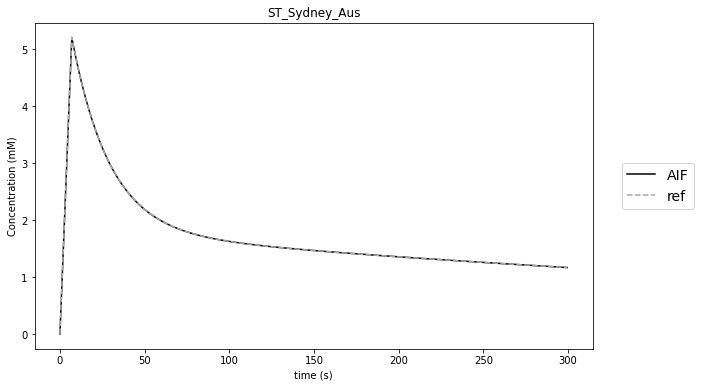

In [5]:
data_original = df[(df['source']=='original')]  

plt.figure()
fig, axs = plt.subplots(1, no_authors, sharey='none',figsize=(10,6))

for current_author in range(no_authors):
    plt.subplot(1,no_authors,current_author+1)
    subset_data = data_original[data_original['author'] == author_list[current_author]]
    plt.plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
    plt.plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
    
    plt.title(author_list[current_author])
    plt.xlabel('time (s)')
    plt.ylabel('Concentration (mM)')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)


### Different acquisition times

There are no errors for different acquisition times.  
This test data was added to check whether the contributions can work with acquisition times different from the original reference.

<Figure size 432x288 with 0 Axes>

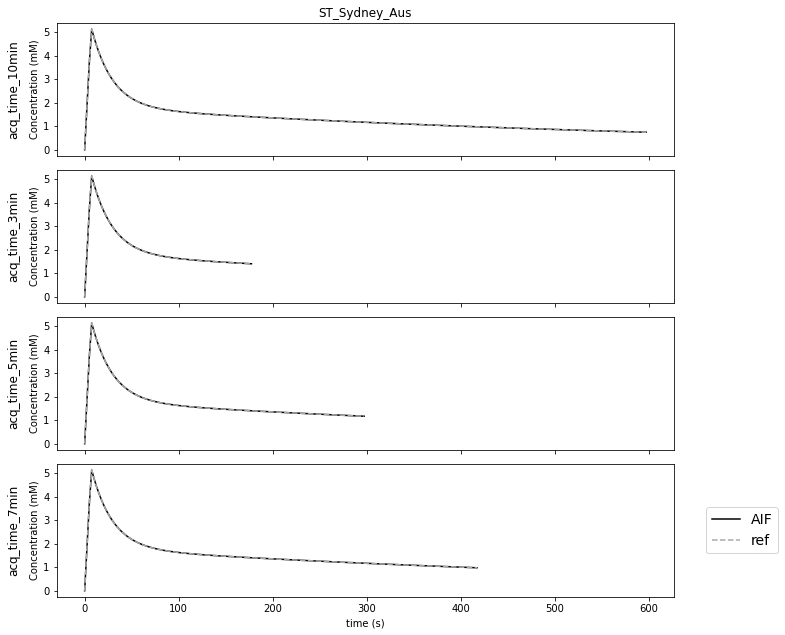

In [6]:
data_acqtime = df[(df['source']=='acq_time')]
acq_list = data_acqtime.label.unique()
no_acq = len(acq_list)

plt.figure()
fig, ax = plt.subplots(no_acq, no_authors, sharex='col', sharey='row', figsize=(12,9))

if no_authors > 1:
    for current_acq in range(no_acq):
        for current_author in range(no_authors):
            subset_data = data_acqtime[(data_acqtime['author'] == author_list[current_author]) & (data_acqtime['label'] == acq_list[current_acq])]
            ax[current_acq,current_author].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
            ax[current_acq,current_author].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')

            if current_acq == 0:
                ax[current_acq,current_author].set_title(author_list[current_author])
            if current_author == 0:
                ax[current_acq,current_author].set_ylabel('Concentration (mM)')
            if current_acq == no_acq-1:
                ax[current_acq,current_author].set_xlabel('time (s)')

    ax[no_acq-1,no_authors-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

    # add extra labels for rows (example taken from: https://microeducate.tech/row-and-column-headers-in-matplotlibs-subplots/)
    pad = 5
    for a, row in zip(ax[:,0], acq_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    
else:
    for current_acq in range(no_acq):
        subset_data = data_acqtime[(data_acqtime['author'] == author_list[current_author]) & (data_acqtime['label'] == acq_list[current_acq])]
        ax[current_acq].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
        ax[current_acq].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
        ax[current_acq].set_ylabel('Concentration (mM)')
        
        if current_acq == 0:
            ax[current_acq].set_title(author_list[current_author])         
        if current_acq == no_acq-1:
            ax[current_acq].set_xlabel('time (s)')
            
    ax[no_acq-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)
    #add extra labels for rows
    pad = 5        
    for a, row in zip(ax, acq_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                xycoords=a.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

        
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)


### Different temporal resolutions

There are no errors for various temporal resolutions  
This test data was added to check whether the contributions can work with temporal resolutions different from the original reference.

<Figure size 432x288 with 0 Axes>

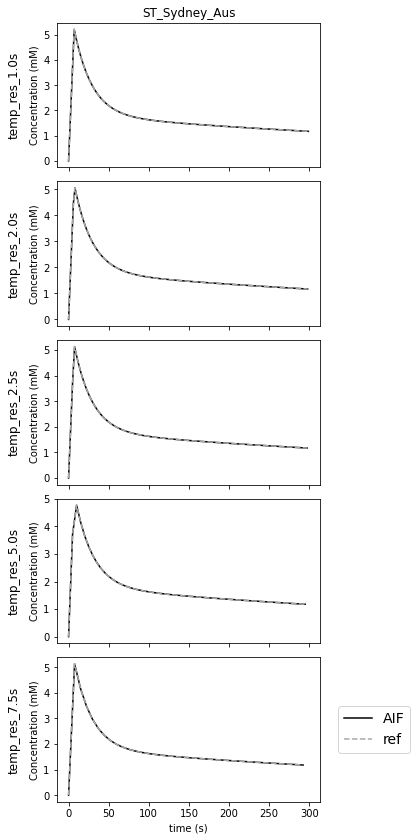

In [7]:
data_res = df[(df['source']=='temp_res')]
res_list = data_res.label.unique()
no_res = len(res_list)

plt.figure()
fig, ax = plt.subplots(no_res, no_authors, sharex='col', sharey='row', figsize=(6,12))

if no_authors > 1:
    for current_res in range(no_res):
        for current_author in range(no_authors):
            subset_data = data_res[(data_res['author'] == author_list[current_author]) & (data_res['label'] == res_list[current_res])]
            ax[current_res,current_author].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
            ax[current_res,current_author].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')

            if current_res == 0:
                ax[current_res,current_author].set_title(author_list[current_author])
            if current_author == 0:
                ax[current_res,current_author].set_ylabel('Concentration (mM)')
            if current_res == no_res-1:
                ax[current_res,current_author].set_xlabel('time (s)')

    ax[no_res-1,no_authors-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)
    
    #add extra labels for rows
    pad = 5
    for a, row in zip(ax[:,0], res_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)
    
else:
    for current_res in range(no_res):
        subset_data = data_res[(data_res['author'] == author_list[current_author]) & (data_res['label'] == res_list[current_res])]
        ax[current_res].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
        ax[current_res].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
        ax[current_res].set_ylabel('Concentration (mM)')
        
        if current_res == 0:
            ax[current_res].set_title(author_list[current_author])         
        if current_res == no_res-1:
            ax[current_res].set_xlabel('time (s)')
    
    #add extra labels for rows
    pad = 5
    for a, row in zip(ax, res_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    ax[no_res-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

### Variations in bolus arrival time

This test data was added to check how contributions deal with a difference in bolus arrival time.

<Figure size 432x288 with 0 Axes>

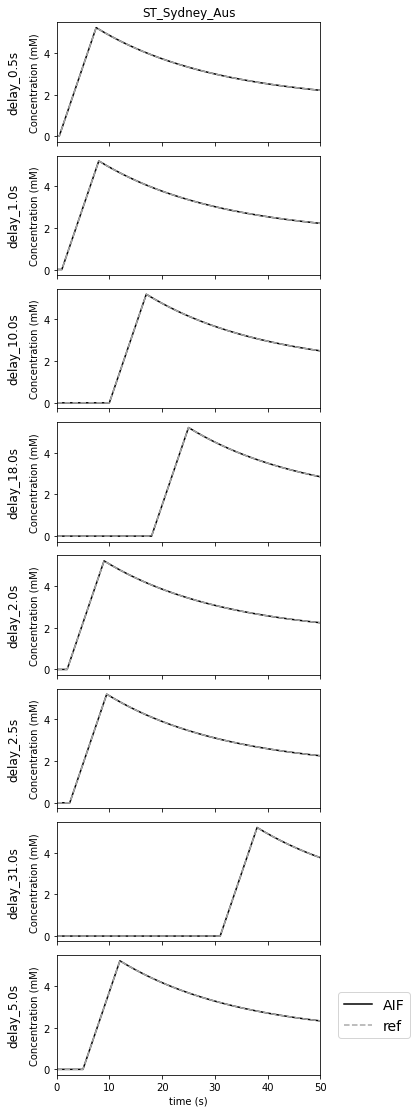

In [8]:
data_delay = df[(df['source']=='delay')]
delay_list = data_delay.label.unique()
no_delay = len(delay_list)

plt.figure()
fig, ax = plt.subplots(no_delay, no_authors, sharex='col', sharey='row', figsize=(6,16))

if no_authors > 1:
    for current_delay in range(no_delay):
        for current_author in range(no_authors):
            subset_data = data_delay[(data_delay['author'] == author_list[current_author]) & (data_delay['label'] == delay_list[current_delay])]
            ax[current_delay,current_author].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
            ax[current_delay,current_author].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')

            if current_delay == 0:
                ax[current_delay,current_author].set_title(author_list[current_author])
            if current_author == 0:
                ax[current_delay,current_author].set_ylabel('Concentration (mM)')
            if current_delay == no_res-1:
                ax[current_delay,current_author].set_xlabel('time (s)')

            ax[current_delay,current_author].set_xlim([0, 50])

    ax[no_delay-1,no_authors-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

    # add extra labels for rows
    pad = 5
    for a, row in zip(ax[:,0], delay_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)
    
else:
    for current_delay in range(no_delay):
        subset_data = data_delay[(data_delay['author'] == author_list[current_author]) & (data_delay['label'] == delay_list[current_delay])]
        ax[current_delay].plot(subset_data.time_ref, subset_data.cb_measured, color='black',label ="AIF")
        ax[current_delay].plot(subset_data.time_ref, subset_data.aif_ref, color='darkgrey', linestyle='dashed', label='ref')
        ax[current_delay].set_ylabel('Concentration (mM)')
        
        if current_delay == 0:
            ax[current_delay].set_title(author_list[current_author])         
        if current_delay == no_delay-1:
            ax[current_delay].set_xlabel('time (s)')
            
        ax[current_delay].set_xlim([0, 50])
    
    #add extra labels for rows
    pad = 5
    for a, row in zip(ax, delay_list):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
                    xycoords=a.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    ax[no_delay-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", fontsize=14)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

## Notes
Additional notes/remarks

### References
McGrath et al. "Comparison of Model-Based Arterial Input Functions forDynamic Contrast-Enhanced MRI in Tumor Bearing Rats", Magn Reson Med (2009), DOI: 10.1002/mrm.21959